# Optimizing the parameters of a coarse-grained potential using jaxDNA

jaxDNA [1] is a sandbox for developing, parameterizing, and testing biomolecular models. It currently has the oxDNA family of models implemented (oxDNA [2-4], oxRNA [5], oxNA [6]) and extensions to lipid and protein models are actively being pursued. The philosophy of the software is as follows:

jax_dna_opt_diagram (1).svg

Currently, the supported *simulators* are **Jax-MD** and the **oxDNA** standalone C++/CUDA codes, but extensions to support **GROMACS** and **OpenMM** are being developed.

An *optimizer* computes gradients of the chosen *objective* functions with respect to the parameters, then performs gradient descent with an optimizer of choice (e.g. RMSProp, Adam, etc). There are two strategies for computing gradients implemented at present: **direct automatic differentiation** and **differentiable trajectory reweighting (DiffTRE)**.

It is only possible to use **direct automatic differentiation** with the **Jax-MD** simulator because other MD codebases (including **oxDNA**) are not differentiable. In practice, we have found that the oxDNA energy function is sufficiently complex that computing gradients directly through unrolled simulated trajectories leads to exploding gradients unless timesteps are taken very small, so small as to render calculations very computationally expensive. An alternative is to use the **DiffTRE** method of Zhang *et al.* [7] and Thaler and Zavadlev [8], which expresses observables under different parameter sets as weighted averages over a given ensemble of simulated trajectories. The ensemble is re-sampled only periodically. This method must be implemented in a differentiable language like Jax-MD because gradients of energy functions and of the average over sampled states are still computed automatically.

While the software implements the oxDNA family of models as a starting point, it flexibly supports custom geometries and energy functions. One can also augment existing oxDNA models with custom energy functions, as we'll see below.

This tutorial is meant to introduce the user to the power of jaxDNA by (i) implementing a simple reparameterization of the oxDNA 1.0 model to produce a different DNA helical pitch value and (ii) adding a custom energy function to the oxDNA model and parameterizing it.

## Imports & Utils

In [ ]:
#install from Github repo
!pip install git+https://github.com/rkruegs123/jax-dna.git
# Need to uninstall the current jax_md due to a version conflict
!pip uninstall -y jax_md
# install the latest version directly from GitHub
!pip install git+https://github.com/jax-md/jax-md.git
#!pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install ray

  Cloning https://github.com/rkruegs123/jax-dna.git to /tmp/pip-req-build-j6d0dyz0
  Running command git clone --filter=blob:none --quiet https://github.com/rkruegs123/jax-dna.git /tmp/pip-req-build-j6d0dyz0
  Resolved https://github.com/rkruegs123/jax-dna.git to commit 659c5fc56b81715c52fb35c6e6a80f7cf10582c1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.0/151.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 373.8/373.8 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.9/168.9 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 9.8 MB/s eta 0:00:00
  Created wheel for jax_dna: filename=jax_dna-0.1.dev1313+g659c5fc-py3-none-

Found existing installation: jax-md 0.2.8
Uninstalling jax-md-0.2.8:
  Successfully uninstalled jax-md-0.2.8
  Cloning https://github.com/jax-md/jax-md.git to /tmp/pip-req-build-1q_64naq
  Running command git clone --filter=blob:none --quiet https://github.com/jax-md/jax-md.git /tmp/pip-req-build-1q_64naq
  Resolved https://github.com/jax-md/jax-md.git to commit 3571f47bd37a4a1d316d68797ed16f52add5e743
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.0/809.0 kB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install wget
!wget https://raw.githubusercontent.com/rkruegs123/jax-dna/master/data/sys-defs/simple-helix/sys.top
!wget https://raw.githubusercontent.com/rkruegs123/jax-dna/master/data/sys-defs/simple-helix/bound_relaxed.conf


  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=bd660f836f96c33e4e43ac95d5adc61c8998efa56dd5ca8dad77b30b855c719f
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget
--2025-04-28 00:42:30--  https://raw.githubusercontent.com/rkruegs123/jax-dna/master/data/sys-defs/simple-helix/sys.top
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 148 [text/plain]
Saving to: ‘sys.top’

sys.top             100%[===================>]     148  --.-KB/s    in 0s      

2025-04-28 00:42:30 (2.43 MB/s) - ‘sys.top’ saved [148/148]

--2025-04-28 00:42:30--  https://raw.githubusercontent.com/rkruegs123/jax-dna/master/data/sys-defs/simpl

In [ ]:
import functools
import itertools
import logging
import os
from pathlib import Path
import typing
import jax
import jax.numpy as jnp
import jax_md
import optax
import sys
from tqdm import tqdm
import operator
import numpy as onp
import matplotlib.pyplot as plt

import jax_dna
import jax_dna.energy as jdna_energy
import jax_dna.energy.dna1 as dna1_energy
import jax_dna.energy.utils as jdna_utils
import jax_dna.input.toml as toml_reader
import jax_dna.input.tree as jdna_tree
import jax_dna.observables as jd_obs
import jax_dna.observables.pitch as pitch
import jax_dna.observables.propeller as propeller
import jax_dna.optimization.simulator as jdna_simulator
import jax_dna.optimization.objective as jdna_objective
import jax_dna.optimization.optimization as jdna_optimization
import jax_dna.simulators.oxdna as oxdna
import jax_dna.simulators.io as jdna_sio
import jax_dna.simulators.jax_md as jdna_jaxmd
import jax_dna.utils.types as jdna_types
from jax_dna.ui.loggers.logger import Logger
import jax_dna.ui.loggers.jupyter as jdna_jupyter
from jax_dna.input import topology, trajectory
import jax_dna.input.topology as jdna_top
import jax_dna.input.trajectory as jdna_traj
import jax_dna.utils.units as units
import jax_dna.utils.math as jd_math
import jax_dna.energy.base as je_base
import jax_dna.energy.configuration as config
import jax_dna.energy.dna1.base_smoothing_functions as bsf
import jax_dna.energy.dna1.interactions as dna1_interactions
import jax_dna.energy.dna1.base_functions as jd_base_functions
import jax_dna.energy.potentials as jdna_potentials




jax.config.update("jax_enable_x64", True)
#file_path = Path("../../../data/sys-defs/simple-helix")
file_path = Path(".")

In [ ]:
##for generating plots

from google.colab import output
output.enable_custom_widget_manager()
from IPython.display import display, clear_output
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import time

##FIRST OPTIMIZATION
# Function to create and display figure
def update_plots(TARGET_PITCH, N_ITERS, grads=None):
    # Create figure with 2 subplots side by side
    fig = make_subplots(rows=2, cols=2,
                        subplot_titles=("Loss", "Pitch", "Largest gradients"),
                        specs=[
                          [{"type": "scatter"}, {"type": "scatter"}],  # First row: two separate plots
                          [{"type": "bar", "colspan": 2}, None]        # Second row: one wide plot
                        ],
                        vertical_spacing=0.15,
                        horizontal_spacing=0.2)

    # Add traces for each subplot
    fig.add_trace(go.Scatter(x=loss_x, y=loss_y, mode='lines+markers', name='Loss'),
                 row=1, col=1)

    fig.add_trace(go.Scatter(x=pitch_x, y=pitch_y, mode='lines+markers', name='Pitch'),
                 row=1, col=2)

    # Add target line
    fig.add_trace(
        go.Scatter(
            x=[-1, N_ITERS],
            y=[TARGET_PITCH, TARGET_PITCH],
            mode='lines',
            line=dict(color='red', width=2, dash='dash'),
            name='Target Pitch',
            showlegend=True
        ),
        row=1, col=2
    )
    # Add largest gradient values bar plot if data is available
    if grads:
        param_names = [name for name, _ in grads]
        param_values = [value for _, value in grads]

        fig.add_trace(
            go.Bar(
                x=param_names,
                y=param_values,
                text=[f"{v:.6f}" for v in param_values],
                textposition='auto',
                name='Gradient Value'
            ),
            row=2, col=1
        )

    fig.update_layout(
        autosize=False,
        width=900,
        height=700,  # Increased height to accommodate the new plot
        margin=dict(l=50, r=50, t=60, b=50),
    )

    # Set x-axis labels and ranges
    fig.update_xaxes(title_text="Iteration", range=[-1, N_ITERS], row=1, col=1)
    fig.update_xaxes(title_text="Iteration", range=[-1, N_ITERS], row=1, col=2)
    fig.update_xaxes(title_text="Parameter", row=2, col=1)

    # Set y-axis labels and ranges
    fig.update_yaxes(title_text="Loss (A.U.)", range=[0, 0.12], row=1, col=1)
    fig.update_yaxes(title_text="Pitch (bps/turn)", range=[9.5, 13.5], row=1, col=2)
    fig.update_yaxes(title_text="Gradient Value", row=2, col=1)

    # Clear previous output and display new figure
    clear_output(wait=True)
    display(fig)

def find_largest_differences(list_dict1, list_dict2, top_n=5):
    # Convert lists of dictionaries to dictionaries if needed
    if isinstance(list_dict1, list) and isinstance(list_dict2, list):
        # Assuming each list contains dictionaries that need to be combined
        dict1 = {}
        for d in list_dict1:
            dict1.update(d)

        dict2 = {}
        for d in list_dict2:
            dict2.update(d)
    else:
        # Already dictionaries
        dict1 = list_dict1
        dict2 = list_dict2

    # Create a dictionary to store the percentage differences
    differences = {}

    # Compute the percentage difference for each key
    for key in dict1:
        if key in dict2 and dict1[key] != 0:  # Avoid division by zero
            # Calculate percentage difference: (final - initial) / initial * 100
            differences[key] = abs((dict2[key] - dict1[key]) / dict1[key] * 100)

    # Sort the differences by value in descending order and get the top n
    top_keys = sorted(differences.items(), key=lambda x: x[1], reverse=True)[:top_n]

    return top_keys, dict1, dict2

def plot_top_differences(dict1, dict2, top_differences):
    # Extract keys from top differences
    keys = [item[0] for item in top_differences]

    # Get the values for these keys from both dictionaries
    values1 = [dict1[key] for key in keys]
    values2 = [dict2[key] for key in keys]
    percent_changes = [(dict2[key] - dict1[key]) / dict1[key] * 100 for key in keys]

    # Set up the plot
    x = onp.arange(len(keys))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))

    # Create the bars
    rects1 = ax.bar(x - width/2, values1, width, label='Initial Values')
    rects2 = ax.bar(x + width/2, values2, width, label='Final Values')

    # Add labels, title and legend
    ax.set_xlabel('Keys')
    ax.set_ylabel('Values')
    ax.set_title('Top 5 Parameters with Largest Percentage Differences')
    ax.set_xticks(x)
    ax.set_xticklabels(keys)
    ax.legend()

    # Add value labels on top of each bar with percentage change
    def autolabel(rects, values, percent_changes):
        for i, rect in enumerate(rects):
            height = rect.get_height()
            label = f'{values[i]:.2f}'
            if i < len(percent_changes) and rect in rects2:  # Only add % change to final values
                label += f'\n({percent_changes[i]:+.1f}%)'

            ax.annotate(label,
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1, values1, [])
    autolabel(rects2, values2, percent_changes)

    plt.tight_layout()
    plt.show()

##MULTI-OBJECTIVE LOSS DEMO

def update_dual_plots(TARGET_VALUE1, TARGET_VALUE2, N_ITERS, observable1_name="Pitch", observable2_name="Propeller Twist", observable1_units="bps/turn", observable2_units="rads"):
    # Create figure with 2x2 grid of subplots
    fig = make_subplots(rows=2, cols=2,
                        subplot_titles=(f"Loss for {observable1_name}",
                                       f"{observable1_name}",
                                       f"Loss for {observable2_name}",
                                       f"{observable2_name}"),
                        vertical_spacing=0.15,
                        horizontal_spacing=0.15)

    # Add traces for each subplot
    # First optimization - loss
    fig.add_trace(go.Scatter(x=loss1_x, y=loss1_y, mode='lines+markers', name=f'Loss ({observable1_name})'),
                 row=1, col=1)

    # First optimization - observable value
    fig.add_trace(go.Scatter(x=observable1_x, y=observable1_y, mode='lines+markers', name=observable1_name),
                 row=1, col=2)

    # Add target line for first observable
    fig.add_trace(
        go.Scatter(
            x=[-1, N_ITERS],
            y=[TARGET_VALUE1, TARGET_VALUE1],
            mode='lines',
            line=dict(color='red', width=2, dash='dash'),
            name=f'Target {observable1_name}',
            showlegend=True
        ),
        row=1, col=2
    )

    # Second optimization - loss
    fig.add_trace(go.Scatter(x=loss2_x, y=loss2_y, mode='lines+markers', name=f'Loss ({observable2_name})'),
                 row=2, col=1)

    # Second optimization - observable value
    fig.add_trace(go.Scatter(x=observable2_x, y=observable2_y, mode='lines+markers', name=observable2_name),
                 row=2, col=2)

    # Add target line for second observable
    fig.add_trace(
        go.Scatter(
            x=[-1, N_ITERS],
            y=[TARGET_VALUE2, TARGET_VALUE2],
            mode='lines',
            line=dict(color='red', width=2, dash='dash'),
            name=f'Target {observable2_name}',
            showlegend=True
        ),
        row=2, col=2
    )

    fig.update_layout(
        autosize=False,
        width=1000,
        height=800,
        margin=dict(l=50, r=50, t=60, b=50),
    )

    # Set x-axis labels and ranges
    fig.update_xaxes(title_text="Iteration", range=[-1, N_ITERS], row=1, col=1)
    fig.update_xaxes(title_text="Iteration", range=[-1, N_ITERS], row=1, col=2)
    fig.update_xaxes(title_text="Iteration", range=[-1, N_ITERS], row=2, col=1)
    fig.update_xaxes(title_text="Iteration", range=[-1, N_ITERS], row=2, col=2)

    # Set y-axis labels and ranges
    # You may need to adjust the y-ranges based on your expected data values
    fig.update_yaxes(title_text="Loss (A.U.)", row=1, col=1)
    fig.update_yaxes(title_text=f"{observable1_name} ({observable1_units})", row=1, col=2)
    fig.update_yaxes(title_text="Loss (A.U.)", row=2, col=1)
    fig.update_yaxes(title_text=f"{observable2_name} ({observable2_units})", row=2, col=2)

    # Clear previous output and display new figure
    clear_output(wait=True)
    display(fig)

###CUSTOM ENERGY LOSS DEMOS
def update_plots_dh(TARGET_VALUE, N_ITERS, observable_name="Pitch", observable_units="bps/turn"):
    # Create figure with 2 subplots side by side
    fig = make_subplots(rows=1, cols=2,
                       subplot_titles=("Loss", observable_name),
                       horizontal_spacing=0.2)

    # Add traces for each subplot
    fig.add_trace(go.Scatter(x=dh_loss_x, y=dh_loss_y, mode='lines+markers', name='Loss'),
                 row=1, col=1)

    fig.add_trace(go.Scatter(x=dh_observable_x, y=dh_observable_y, mode='lines+markers', name=observable_name),
                 row=1, col=2)

    # Add target line
    fig.add_trace(
        go.Scatter(
            x=[-1, N_ITERS],
            y=[TARGET_VALUE, TARGET_VALUE],
            mode='lines',
            line=dict(color='red', width=2, dash='dash'),
            name=f'Target {observable_name}',
            showlegend=True
        ),
        row=1, col=2
    )

    fig.update_layout(
        autosize=False,
        width=900,
        height=400,
        margin=dict(l=50, r=50, t=60, b=50),
    )

    # Set x-axis labels and ranges
    fig.update_xaxes(title_text="Iteration", range=[-1, N_ITERS], row=1, col=1)
    fig.update_xaxes(title_text="Iteration", range=[-1, N_ITERS], row=1, col=2)

    # Set y-axis labels and ranges
    fig.update_yaxes(title_text="Loss (A.U.)", row=1, col=1)
    fig.update_yaxes(title_text=f"{observable_name} ({observable_units})", row=1, col=2)

    # Clear previous output and display new figure
    clear_output(wait=True)
    display(fig)

def update_plots_mlp(TARGET_VALUE, N_ITERS, observable_name="Pitch", observable_units="bps/turn"):
    # Create figure with 2 subplots side by side
    fig = make_subplots(rows=1, cols=2,
                       subplot_titles=("Loss", observable_name),
                       horizontal_spacing=0.2)

    # Add traces for each subplot
    fig.add_trace(go.Scatter(x=mlp_loss_x, y=mlp_loss_y, mode='lines+markers', name='Loss'),
                 row=1, col=1)

    fig.add_trace(go.Scatter(x=mlp_observable_x, y=mlp_observable_y, mode='lines+markers', name=observable_name),
                 row=1, col=2)

    # Add target line
    fig.add_trace(
        go.Scatter(
            x=[-1, N_ITERS],
            y=[TARGET_VALUE, TARGET_VALUE],
            mode='lines',
            line=dict(color='red', width=2, dash='dash'),
            name=f'Target {observable_name}',
            showlegend=True
        ),
        row=1, col=2
    )

    fig.update_layout(
        autosize=False,
        width=900,
        height=400,
        margin=dict(l=50, r=50, t=60, b=50),
    )

    # Set x-axis labels and ranges
    fig.update_xaxes(title_text="Iteration", range=[-1, N_ITERS], row=1, col=1)
    fig.update_xaxes(title_text="Iteration", range=[-1, N_ITERS], row=1, col=2)

    # Set y-axis labels and ranges
    fig.update_yaxes(title_text="Loss (A.U.)", row=1, col=1)
    fig.update_yaxes(title_text=f"{observable_name} ({observable_units})", row=1, col=2)

    # Clear previous output and display new figure
    clear_output(wait=True)
    display(fig)


In [ ]:
def write_to_file(
    filepath: jdna_types.PathOrStr,
    traj: jdna_sio.SimulatorTrajectory,
    print_every: int) -> None:
    """Write a jaxDNA simulation trajectory to oxDNA file format for visualization purposes."""
    num_nucs = len(traj.rigid_body.center[0])
    v = jnp.zeros((num_nucs, 3)) #dummy velocity for now
    L = jnp.zeros((num_nucs, 3)) #dummy angular momentum for now
    #FIXME: SimulatorTrajectory only stores every print_conf_interval snapshots. Need to multiply t by print_conf_interval, read from the oxDNA input file
    with open(filepath, "w") as f:
        for i in jnp.arange(0, traj.length(), print_every):
            f.write(f"t = {i}\n")
            f.write("b = 50. 50. 50.\n")
            f.write("E = 0. 0. 0.\n")

            coms = traj.rigid_body.center[i]
            bb_vecs = jdna_utils.q_to_back_base(traj.rigid_body.orientation[i])
            base_norms = jdna_utils.q_to_base_normal(traj.rigid_body.orientation[i])

            rows = jnp.hstack((coms, bb_vecs, base_norms, v, L))
            for row in rows:
                f.write(' '.join(map(str, row)) + '\n')

## 1. Simulate a simple helix with Jax-MD

#### Set up simulation parameters

In [ ]:
sim_config = {
    "n_steps": 5_000,
    "kT": 293.15,
    "dt": 0.003,
}

#load system topology and initial position

top = jdna_top.from_oxdna_file(file_path / "sys.top") #load topology
initial_positions = ( #load trajectory
    jdna_traj.from_file(
        file_path / "bound_relaxed.conf",
        top.strand_counts,
        is_oxdna=False,
    )
    .states[0]
    .to_rigid_body()
)

default_sim_params, default_model_params = dna1_energy.default_configs()

dt = sim_config["dt"]
kT = units.get_kt(sim_config["kT"])
diff_coef = default_sim_params["diff_coef"]
rot_diff_coef = default_sim_params["rot_diff_coef"]
gamma = jax_md.rigid_body.RigidBody(
    center=jnp.array([kT / diff_coef], dtype=jnp.float64),
    orientation=jnp.array([kT / rot_diff_coef], dtype=jnp.float64),
)
mass = jax_md.rigid_body.RigidBody(
    center=jnp.array([default_sim_params["nucleotide_mass"]], dtype=jnp.float64),
    orientation=jnp.array([default_sim_params["moment_of_inertia"]], dtype=jnp.float64),
)
geometry = default_model_params["geometry"]
transform_fn = functools.partial(
    dna1_energy.Nucleotide.from_rigid_body,
    com_to_backbone=geometry["com_to_backbone"],
    com_to_hb=geometry["com_to_hb"],
    com_to_stacking=geometry["com_to_stacking"],
)

#### Set up energy model

In JaxDNA, energy functions comprise a functional form and a *configuration*, which specifies the parameters needed by the energy function. Some of these parameters may be ``dependent'' on others, such as parameters of a smoothing function that is constrained to be continuous and differentiable. The configuration and functional forms are put together by the ```jax_dna.energy.energy_fn_builder``` function.

We'll load the default energy configuration, which contains the parameters of the oxDNA1 model, and the default energy functions, which are `Fene`, `BondedExcludedVolume`, `Stacking`, `UnbondedExcludedVolume`, `HydrogenBonding` `CrossStacking`, and `CoaxialStacking`. Finally, we load the default configurations associated with each of these functions, which include information on which parameters are free and which should be computed from the others (i.e. smoothing function parameters).

In [ ]:
# The jax_md simulator needs an energy function. We can use the default
# energy functions and configurations for dna1 simulations. For more
# information on energy functions and configurations, see the documentation.
energy_fn_configs = dna1_energy.default_energy_configs()
params = [{} for _ in range(len(energy_fn_configs))] #empty dictionaries as we won't override any default parameters
energy_fns = dna1_energy.default_energy_fns()

#### Set up MD simulator

We will run simulations with Jax-MD for simplicity (running with the standalone oxDNA code is supported, but would require a working oxDNA binary).

In [ ]:
simulator = jdna_jaxmd.JaxMDSimulator(
    energy_configs=energy_fn_configs,
    energy_fns=energy_fns,
    topology=top,
    simulator_params=jdna_jaxmd.StaticSimulatorParams(
        seq=jnp.array(top.seq),
        mass=mass,
        bonded_neighbors=top.bonded_neighbors,
        checkpoint_every = 100,
        dt=dt,
        kT=kT,
        gamma=gamma,
    ),
    space=jax_md.space.free(),
    transform_fn=transform_fn,
    simulator_init=jax_md.simulate.nvt_langevin,
    neighbors=jdna_jaxmd.NoNeighborList(unbonded_nbrs=top.unbonded_neighbors),
)

key = jax.random.PRNGKey(0)
sim_fn = jax.jit(lambda opts: simulator.run(opts, initial_positions, sim_config["n_steps"], key))


#### Run simulation

In [ ]:
print("Running simulation...")
trajectory = sim_fn(params)
print("Simulation Complete! ✅ Trajectory length:", trajectory.rigid_body.center.shape[0])
write_to_file("trajectory.dat", trajectory, print_every=100)
#jdna_sio.write_to_file("trajectory.dat", trajectory, print_every=100)

Running simulation...
Simulation Complete! ✅ Trajectory length: 5000


#### Visualize the results by downloading `sys.top` and `trajectory.dat` and dragging them to [oxview.org](https://sulcgroup.github.io/oxdna-viewer/)

---



## 2. Optimize the oxDNA model parameters to tighten the pitch of the helix


#### Set optimization parameters

In [ ]:
##set up optimization parameters
opt_config = {
        "n_opt_steps": 5, #how many optimization steps to run for
        "learning_rate": 0.01, #for use with optimizer
}
TARGET_NUM_BPS_PER_TURN=12.
TARGET_PITCH = 2.0*jnp.pi/TARGET_NUM_BPS_PER_TURN

### Set up the energy function builder for parameter optimization

Next, we set up a function to that can 'rebuild' our energy function with each new iteration of parameters -- we'll pass this to the optimizer.

In [ ]:
energy_fn_builder_fn = jdna_energy.energy_fn_builder(
        energy_fns=energy_fns,
        energy_configs=energy_fn_configs,
        transform_fn=transform_fn,
)

We vectorize this energy function so it can act on entire simulation trajectories, calculating the energy at each time step, using vmap:

In [ ]:
def energy_fn_builder(params: jdna_types.Params) -> callable:
      return jax.vmap(
          lambda trajectory: energy_fn_builder_fn(params)(
              trajectory.rigid_body,
              seq=jnp.array(top.seq),
              bonded_neighbors=top.bonded_neighbors,
              unbonded_neighbors=top.unbonded_neighbors.T,
          )
      )

### Set up simulator function

Because jaxDNA supports advanced multi-objective optimization, it is structured to use multiple simulators which expose multiple observables for use in calculating objective functions. We therefore construct a simluation function wrapper that calls the jaxMD simulator, writes the output to a file, and returns the location of this file.

In [ ]:
cwd = Path(os.getcwd())
output_dir = cwd / "basic_trajectory"
trajectory_loc = output_dir / "trajectory.pkl"
if not output_dir.exists():
      output_dir.mkdir(parents=True, exist_ok=True)

def simulator_fn(
      params: jdna_types.Params,
      meta: jdna_types.MetaData,
  ) -> tuple[str, str]:
      in_key=meta["key"]
      in_key, subkey = jax.random.split(in_key)
      traj = simulator.run(params, initial_positions, sim_config["n_steps"], subkey)
      jdna_tree.save_pytree(traj, trajectory_loc)
      return [trajectory_loc]

obs_trajectory = "trajectory"
key = jax.random.PRNGKey(1234)
trajectory_simulator = jdna_simulator.BaseSimulator(
      name="jaxmd-sim",
      fn=simulator_fn,
      exposes = [obs_trajectory],
      meta_data = {"key": key},
  )

### Set up the optimization

First, we specify the parameters we want to optimize. We'll choose to float them all:

In [ ]:
opt_params = []
for ec in energy_fn_configs:
  opt_params.append(
      ec.opt_params #if isinstance(ec, dna1_energy.StackingConfiguration) else {}
      )

##except these weights, which are used for sequence optimizations
for op in opt_params:
  if "ss_stack_weights" in op:
    del op["ss_stack_weights"]
  elif "ss_hb_weights" in op:
    del op["ss_hb_weights"]

Now, we'll define the observable we're interested in optimizing. JaxDNA supports multi-objective optimizations, but for simplicity, we'll consider a single objective: the helical pitch.

In [ ]:
pitch_fn = pitch.PitchAngle(rigid_body_transform_fn=transform_fn,
          quartets=jnp.array([[[2,13],[3,12]],[[3,12],[4,11]],[[4,11],[5,10]]]), # we consider only the inner basepairs to eliminate the effect of fraying
          displacement_fn=jax_md.space.free()[0])

We now define a loss function:

In [ ]:
def pitch_loss_fn(
    traj: jax_md.rigid_body.RigidBody,
    weights: jnp.ndarray,
    energy_model: jdna_energy.base.ComposedEnergyFunction,
) -> tuple[float, tuple[str, typing.Any]]:
    obs = pitch_fn(traj)
    expected_pitch = jnp.dot(weights, obs)
    loss = (expected_pitch - TARGET_PITCH)**2
    loss = jnp.sqrt(loss)
    return loss, (("pitch", expected_pitch), {})

as well as an objective function -- this tells jaxDNA we are going to use DiffTRE to compute our gradients:

In [ ]:
pitch_objective = jdna_objective.DiffTReObjective(
    name = "DiffTRe",
    required_observables = [obs_trajectory],
    needed_observables = [obs_trajectory],
    logging_observables = ["loss", "pitch", "gradients"],
    grad_or_loss_fn = pitch_loss_fn,
    energy_fn_builder = energy_fn_builder,
    opt_params = opt_params,
    min_n_eff_factor = 0.95,
    beta = jnp.array(1/kT),
    n_equilibration_steps = 0,
)

Putting all of this together, we wrap our simulator choice (JaxMD), objective choice (DiffTRE), and an optimizer choice (we'll pick Adam) together using jaxDNA's `SimpleOptimizer` class:

In [ ]:
#opt = jdna_optimization.SimpleOptimizer(
opt = jdna_optimization.SimpleOptimizer(
    objective=pitch_objective,
    simulator=trajectory_simulator,
    optimizer = optax.adam(learning_rate=opt_config["learning_rate"]),
)

/usr/local/lib/python3.11/dist-packages/jax_dna/ui/loggers/logger.py:33: UserWarning: `log_dir` not results might not be saved to disk.
  warnings.warn(MISSING_LOGDIR_WANING, stacklevel=1)


### Run the optimization

In [ ]:
# Initialize data storage
loss_x = []
loss_y = []
pitch_x = []
pitch_y = []

init_params = opt_params
for i in tqdm(range(opt_config["n_opt_steps"])):
        opt_state, opt_params, grads = opt.step(opt_params)
        if i % 1 == 0:
            log_values = pitch_objective.logging_observables()
            for (name, value) in log_values:
                if 'loss' in name.lower():
                    loss_value = value
                if 'pitch' in name.lower():
                    pitch_value = value
                print(f"{i}::{name}={value}")

           # Store data points
            loss_x.append(i)
            loss_y.append(loss_value)
            pitch_x.append(i)
            pitch_y.append(2*jnp.pi/pitch_value)

            flat_params = {}
            for section in grads:
                if isinstance(section, dict):
                    for key, value in section.items():
                        if hasattr(value, 'item'):
                            flat_params[key] = abs(float(value))

            # Get top 6 gradients by absolute value
            current_sorted_grads = sorted(flat_params.items(), key=lambda x: abs(x[1]), reverse=True)[:6]

            # Update the plots
            update_plots(TARGET_PITCH=TARGET_NUM_BPS_PER_TURN, N_ITERS=opt_config["n_opt_steps"],grads=current_sorted_grads)
            time.sleep(0.2)

        opt = opt.post_step(
            optimizer_state=opt_state,
            opt_params=opt_params,
        )
final_params = opt_params

100%|██████████| 5/5 [03:12<00:00, 38.57s/it]


### Compare initial and final parameter values

Top 5 parameter changes:
Key: delta_backbone, Percentage Difference: 18.15%
Key: dr0_hb, Percentage Difference: 12.36%
Key: sigma_back_base, Percentage Difference: 9.16%
Key: r0_cross, Percentage Difference: 8.50%
Key: sigma_base, Percentage Difference: 7.87%


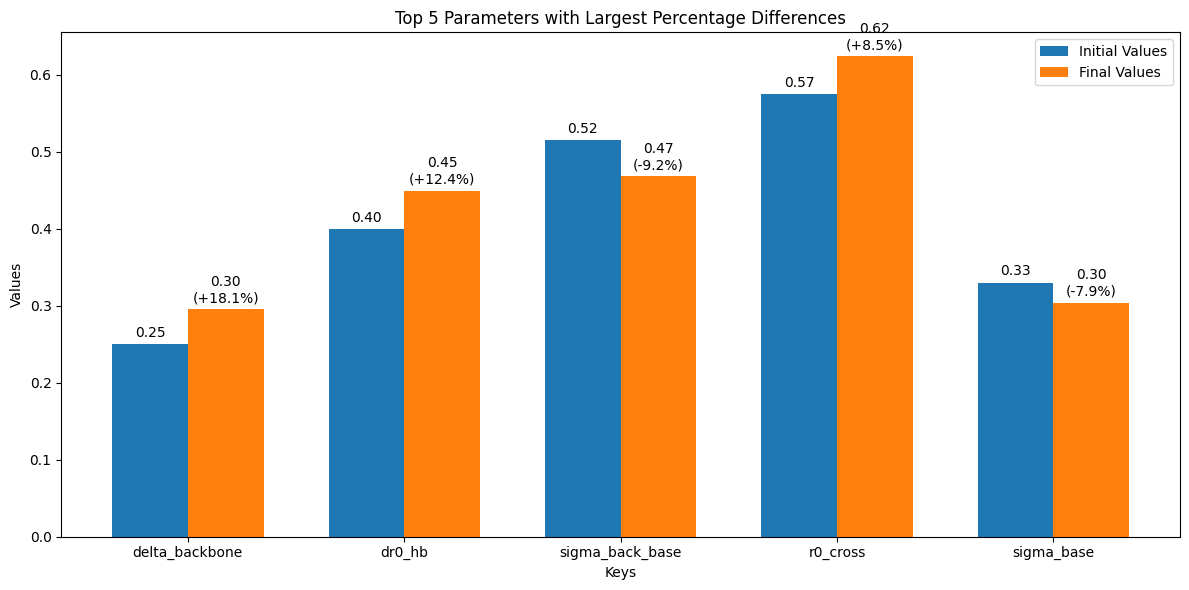

In [ ]:
top_differences, dict1, dict2 = find_largest_differences(init_params, final_params)
print("Top 5 parameter changes:")
for key, diff in top_differences:
    print(f"Key: {key}, Percentage Difference: {diff:.2f}%")

# Plot the top differences
plot_top_differences(dict1, dict2, top_differences)

## 3. Optimize multiple objectives simultaneously

In [ ]:
# The coordination of objectives and simulators is done through Ray actors.
# So we need to initialize a ray server
import ray


ray.init(
    ignore_reinit_error=True,
    log_to_driver=True,
    runtime_env={
        "env_vars": {
            "JAX_ENABLE_X64": "True",
        }
    }
)

multi_opt_config = {
        "n_sim_steps": 1_00,
        "n_opt_steps": 5, #how many optimization steps to run for
        "learning_rate": 0.01, #for use with optimizer
        "batch_size": 1
}
batch_size = multi_opt_config["batch_size"]
            #"JAX_PLATFORM_NAME": "cpu",
            #"JAX_PLATFORMS": "cpu"

2025-04-28 01:29:03,666	INFO worker.py:1684 -- Calling ray.init() again after it has already been called.


In [ ]:
#Specify how to combine gradients from multiple objectives - here, a simple mean
def tree_mean(trees:tuple[jdna_types.PyTree]) -> jdna_types.PyTree:
    if len(trees) <= 1:
        return trees[0]
    summed = jax.tree.map(operator.add, *trees)
    return jax.tree.map(lambda x: x / len(trees), summed)

#reset opt_params to oxDNA1.0 values

opt_params = []
for ec in energy_fn_configs:
  opt_params.append(
      ec.opt_params #if isinstance(ec, dna1_energy.StackingConfiguration) else {}
      )

##except these weights, which are used for sequence optimizations
for op in opt_params:
  if "ss_stack_weights" in op:
    del op["ss_stack_weights"]
  elif "ss_hb_weights" in op:
    del op["ss_hb_weights"]


In [ ]:
def make_simulator(sim_id: int, seed: int):
        output_dir = file_path / f"output{sim_id}" / "trajectory"

        if not output_dir.exists():
            output_dir.mkdir(parents=True, exist_ok=True)

        def simulator_fn(
            params: jdna_types.Params,
            meta: jdna_types.MetaData,
        ) -> tuple[str, str]:
            traj = simulator.run(params, initial_positions, multi_opt_config["n_sim_steps"], seed)
            jdna_tree.save_pytree(traj, output_dir / "trajectory.pkl")
            return [output_dir / "trajectory.pkl"]


        return jdna_simulator.SimulatorActor.options().remote(
            name=sim_id,
            fn=simulator_fn,
            exposes=[f"traj-{sim_id}"],
            meta_data={},
            )

sim_ids = [f"sim{id}" for id in range(batch_size)]
traj_ids = [f"traj-{id}" for id in sim_ids]
key = jax.random.PRNGKey(18112)
batch_keys = jax.random.split(key, batch_size)
simulators = [make_simulator(*id_db) for id_db in zip(sim_ids, batch_keys)]

In [ ]:
#define additional objective
TARGET_PROPELLER_TWIST = 2.

propeller_fn=propeller.PropellerTwist(
            rigid_body_transform_fn=transform_fn,
            h_bonded_base_pairs=jnp.array([[1, 14], [2, 13], [3, 12], [4, 11], [5, 10], [6, 9]])
        )

def propeller_loss_fn(
    traj: jax_md.rigid_body.RigidBody,
    weights: jnp.ndarray,
    energy_model: jdna_energy.base.ComposedEnergyFunction,
) -> tuple[float, tuple[str, typing.Any]]:
    obs = propeller_fn(traj)
    expected_prop_twist = jnp.dot(weights, obs)
    loss = (expected_prop_twist - TARGET_PROPELLER_TWIST)**2
    loss = jnp.sqrt(loss)
    return loss, (("propeller twist", expected_prop_twist), {})

propeller_twist_objective = jdna_objective.DiffTReObjectiveActor.remote(
    name = "DiffTRe_prop",
    required_observables = traj_ids,
    needed_observables = traj_ids,
    logging_observables = ["propeller_loss", "propeller twist", "gradients"],
    grad_or_loss_fn = propeller_loss_fn,
    energy_fn_builder = energy_fn_builder,
    opt_params = opt_params,
    min_n_eff_factor = 0.95,
    beta = jnp.array(1/kT),
    n_equilibration_steps = 0,
)

pitch_objective = jdna_objective.DiffTReObjectiveActor.remote(
    name = "DiffTRe",
    required_observables = traj_ids,
    needed_observables = traj_ids,
    logging_observables = ["pitch_loss", "pitch", "gradients"],
    grad_or_loss_fn = pitch_loss_fn,
    energy_fn_builder = energy_fn_builder,
    opt_params = opt_params,
    min_n_eff_factor = 0.95,
    beta = jnp.array(1/kT),
    n_equilibration_steps = 0,
)

In [ ]:
objectives = [propeller_twist_objective, pitch_objective]

multi_opt = jdna_optimization.Optimization(
    objectives=objectives,
    simulators=simulators,
    optimizer = optax.adam(learning_rate=1e-3),
    aggregate_grad_fn=tree_mean,
)

/usr/local/lib/python3.11/dist-packages/jax_dna/ui/loggers/logger.py:33: UserWarning:

`log_dir` not results might not be saved to disk.



In [ ]:
loss1_x = []
loss1_y = []
observable1_x = []
observable1_y = []

loss2_x = []
loss2_y = []
observable2_x = []
observable2_y = []

for i in tqdm(range(multi_opt_config["n_opt_steps"]), desc="Optimizing"):
    opt_state, opt_params = multi_opt.step(opt_params)

    for objective in multi_opt.objectives:
        log_values = ray.get(objective.logging_observables.remote())
        for (name, value) in log_values:
          print(f"{i}::{name}={value}")
          if 'propeller_loss' in name.lower():
            loss1_x.append(i)
            loss1_y.append(value)
          if 'pitch_loss' in name.lower():
            loss2_x.append(i)
            loss2_y.append(value)

          if 'pitch' in name.lower():
            observable1_x.append(i)
            observable1_y.append(value)
          if 'propeller twist' in name.lower():
            observable2_x.append(i)
            observable2_y.append(value)
     # Update the plots
    update_dual_plots(
        TARGET_VALUE1=TARGET_PITCH,
        TARGET_VALUE2=TARGET_PROPELLER_TWIST,
        N_ITERS=opt_config["n_opt_steps"],
        observable1_name="Pitch",
        observable2_name="Propeller twist",
        observable1_units="bps/turn",
        observable2_units="rads"
     )
    time.sleep(0.2)

    multi_opt = multi_opt.post_step(
        optimizer_state=opt_state,
        opt_params=opt_params,
    )

Optimizing:   0%|          | 0/5 [01:05<?, ?it/s]


ValueError: too many values to unpack (expected 2)

## 4. Custom energy functions

A key contribution of the jaxDNA software environment is the ability to define custom energy functions and parameterize the modified model. Imagine we are interested in adding electrostatics to the oxDNA1 model. We choose to implement the Debye-Huckel interaction potential:


$V_{DH} = \alpha \Sigma_{ij} q_{\text{eff}}^2 \frac{\exp{-r_{ij} / \lambda_{DH}(T,I)}}{r_{ij}}$


Where $\alpha$ is a constant set to 1.14 in oxDNA2, $q_{\text{eff}}$ is an effective charge on each nucleotide, $r_{ij}$ is the internucleotide distance, and $\lambda_{DH}(T,I)$ is the Debye length, given by

$\lambda_{DH}(T,I) = \delta\sqrt{\frac{k_BT}{I}}$

with $\delta$ a constant equal to  0.0817 in oxDNA2, $k_BT$ the thermal energy, and $I$ the salt concentration. In oxDNA2, the Debye-Huckel interaction featured a quadratic ``smoothing'' term, which we also implement below. The original authors [5] used thermodynamic integration to choose a plausible value for $q_{\text{eff}}$. For illustrative purposes, let's try reparameterizing this new electrostatic energy function in the jaxDNA framework.


####Debye-Huckel energy configuration and function

In [ ]:
"""Debye-Huckel custom energy function to add on to the DNA1 model."""

import dataclasses as dc

import chex
import jax.numpy as jnp
import numpy as np
from typing_extensions import override

import jax_dna.energy.base as je_base
import jax_dna.energy.configuration as config
import jax_dna.energy.dna1.base_smoothing_functions as bsf
import jax_dna.energy.dna1.interactions as dna1_interactions
import jax_dna.utils.math as jd_math
import jax_dna.utils.types as typ

LAMBDA_PREFACTOR = 0.3616455*jnp.sqrt(10.) #from oxDNA defs in DNA2Interaction.cpp
DH_PREFACTOR = 0.0543 / (0.815 * 0.815) #from oxDNA defs

def _solve_DH_B(q: typ.Scalar, eta: typ.Scalar, lambda_DH: typ.Scalar) -> typ.Scalar:
    """Solve for the smoothing parameter B in the Debye-Huckel smoothing function."""
    return q**2 * eta / (27. * lambda_DH**2 * jnp.exp(3))


def _solve_DH_rcut(lambda_DH: typ.Scalar) -> typ.Scalar:
    """Solve for the smoothing parameter r_cut in the Debye-Huckel smoothing function."""
    return 6. * lambda_DH

def get_DH_smoothing_params(q: typ.Scalar, eta: typ.Scalar, lambda_DH: typ.Scalar) -> tuple[typ.Scalar, typ.Scalar]:
    """Get the smoothing parameters for the Debye-Huckel smoothing function."""
    solved_B = _solve_DH_B(q, eta, lambda_DH)
    solved_rcut = _solve_DH_rcut(lambda_DH)

    return solved_B, solved_rcut

def v_debye_huckel(r: jdna_types.ARR_OR_SCALAR, DH_prefactor: jdna_types.Scalar, lambda_DH: jdna_types.Scalar) -> jdna_types.ARR_OR_SCALAR:
    """Debye-huckel potential. Based on equation A.2 in Ben Snodin's DPhil thesis."""
    return DH_prefactor * jnp.exp(-r/lambda_DH) / r

def v_debye_huckel_smooth(
    r: jdna_types.ARR_OR_SCALAR,
    qeff: jdna_types.Scalar,
    B_smooth: jdna_types.Scalar,
    r_cut: jdna_types.Scalar,
    lambda_DH: jdna_types.Scalar,
    r_smooth: jdna_types.Scalar,
    dh_prefactor: jdna_types.Scalar,
) -> jdna_types.ARR_OR_SCALAR:
    """Smoothed version of the Debye-Huckel potential."""
    coeff = dh_prefactor * qeff * qeff


    return jnp.where(
        r > r_cut,
        0.0,  # Case 1: r > r_cut → return 0
        jnp.where(
            r > r_smooth,
            jdna_potentials.v_smooth(r, B_smooth, r_cut),  # Case 2: r_smooth < r < r_cut → return V_smooth
            v_debye_huckel(r, coeff, lambda_DH)   # Case 3: r < r_smooth → return V_debye_huckel
        )
    )

@chex.dataclass(frozen=True)
class DebyeHuckelConfiguration(config.BaseConfiguration):
    """Configuration for the Debye-Huckel energy function."""

    # independent parameters
    qeff: float | None = None
    kt: float | None = None
    salt_I: float | None = None

    # dependent parameters
    B_smooth: float | None = None
    r_cut: float | None = None
    lambda_DH: float | None = None
    r_smooth: float | None = None

    required_params: tuple[str] = (
        "qeff",
        "kt",
        "salt_I",
    )

    dependent_params: tuple[str] = (
        "B_smooth",
        "r_cut",
        "lambda_DH",
        "r_smooth",
    )

    @override
    def init_params(self) -> "DebyeHuckelConfiguration":
        _lambda_DH = LAMBDA_PREFACTOR * jnp.sqrt(self.kt / self.salt_I)
        _r_smooth = 3. * _lambda_DH

        _B, _r_cut = get_DH_smoothing_params(
            self.qeff,
            DH_PREFACTOR,
            _lambda_DH,
        )

        return self.replace(
            B_smooth=_B,
            r_cut=_r_cut,
            lambda_DH = _lambda_DH,
            r_smooth = _r_smooth,
        )


@chex.dataclass(frozen=True)
class DebyeHuckel(je_base.BaseEnergyFunction):
    """Debye-Huckel energy function for adding electrostatics to the DNA1 model."""

    params: DebyeHuckelConfiguration

    def pairwise_energies(
        self,
        body_i: je_base.BaseNucleotide,
        body_j: je_base.BaseNucleotide,
        unbonded_neighbors: jdna_types.Arr_Unbonded_Neighbors_2,
    ) -> jdna_types.Arr_Unbonded_Neighbors:
        """Computes the Debye-Huckel electrostatic energy for each unbonded (i.e. non-neighbor) pair."""
        op_i = unbonded_neighbors[0]
        op_j = unbonded_neighbors[1]

        mask = jnp.array(op_i < body_i.center.shape[0], dtype=jnp.float32)

        dr_bb_op = self.displacement_mapped(body_j.back_sites[op_j], body_i.back_sites[op_i])
        r_bb_op = jnp.linalg.norm(dr_bb_op, axis=1) #distance between backbone sites, where we place the charge

        debye_huckel_dg = v_debye_huckel_smooth(
            r_bb_op,
            self.params.qeff,
            self.params.B_smooth,
            self.params.r_cut,
            self.params.lambda_DH,
            self.params.r_smooth,
            DH_PREFACTOR,
        )
        return jnp.where(mask, debye_huckel_dg, 0.0)  # Mask for neighbors

    @override
    def __call__(
        self,
        body: je_base.BaseNucleotide,
        seq: jdna_types.Sequence,
        bonded_neighbors: jdna_types.Arr_Bonded_Neighbors_2,
        unbonded_neighbors: jdna_types.Arr_Unbonded_Neighbors_2,
    ) -> jdna_types.Scalar:
        dgs = self.pairwise_energies(body, body, unbonded_neighbors)
        return dgs.sum()

####Training Debye-Huckel energy function

In [ ]:
DebyeHuckel_train_config = {
        "n_sim_steps": 5_00,
        "n_opt_steps": 5,
        "learning_rate": 0.1,
    }

TARGET_PITCH = 2.0*jnp.pi/10.0 #imagine we have a salt-dependent pitch value we want to match

#get default simulation configuration and energy configuration values
dh_energy_fns = dna1_energy.default_energy_fns()
dh_energy_fn_configs = dna1_energy.default_energy_configs()

# create Debye-Huckel configuration
dh_params = {
    "qeff": 0.615,
    "kt": sim_config["kT"],
    "salt_I": 0.15
}
dh_config = DebyeHuckelConfiguration.from_dict(
    dh_params,
    params_to_optimize=("qeff",)
    ).init_params()

# Append to the energy configs and functions
dh_energy_fn_configs.append(dh_config)
dh_energy_fns.append(DebyeHuckel)

#we'll only optimize the q_eff
opt_params = []
for ec in dh_energy_fn_configs:
    if isinstance(ec, DebyeHuckelConfiguration):
        opt_params.append(ec.opt_params)
    else:
        opt_params.append({})

print("optimizing parameters: ",opt_params)


dh_energy_fn_builder_fn = jdna_energy.energy_fn_builder(
    energy_fns=dh_energy_fns,
    energy_configs=dh_energy_fn_configs,
    transform_fn=transform_fn,
)

def dh_energy_fn_builder(params: jdna_types.Params) -> callable:
    return jax.vmap(
        lambda trajectory: dh_energy_fn_builder_fn(params)(
            trajectory.rigid_body,
            seq=jnp.array(top.seq),
            bonded_neighbors=top.bonded_neighbors,
            unbonded_neighbors=top.unbonded_neighbors.T,
        )
    )

cwd = Path(os.getcwd())
output_dir = cwd / "dh_trajectory"
trajectory_loc = output_dir / "trajectory.pkl"
if not output_dir.exists():
    output_dir.mkdir(parents=True, exist_ok=True)

dh_simulator = jdna_jaxmd.JaxMDSimulator(
    energy_configs=dh_energy_fn_configs,
    energy_fns=dh_energy_fns,
    topology=top,
    simulator_params=jdna_jaxmd.StaticSimulatorParams(
        seq=jnp.array(top.seq),
        mass=mass,
        bonded_neighbors=top.bonded_neighbors,
        checkpoint_every = 100,
        dt=dt,
        kT=kT,
        gamma=gamma,
    ),
    space=jax_md.space.free(),
    transform_fn=transform_fn,
    simulator_init=jax_md.simulate.nvt_langevin,
    neighbors=jdna_jaxmd.NoNeighborList(unbonded_nbrs=top.unbonded_neighbors),
)

def simulator_fn(
    params: jdna_types.Params,
    meta: jdna_types.MetaData,
) -> tuple[str, str]:
    in_key=meta["key"]
    in_key, subkey = jax.random.split(in_key)
    traj = dh_simulator.run(params, initial_positions, DebyeHuckel_train_config["n_sim_steps"], subkey)
    jdna_tree.save_pytree(traj, trajectory_loc)
    return [trajectory_loc]

obs_trajectory = "trajectory"

key = jax.random.PRNGKey(1234)
trajectory_simulator = jdna_simulator.BaseSimulator(
    name="jaxmd-sim",
    fn=simulator_fn,
    exposes = [obs_trajectory],
    meta_data = {"key": key},
)

pitch_fn = pitch.PitchAngle(rigid_body_transform_fn=transform_fn,
        quartets=jnp.array([[[2,13],[3,12]],[[3,12],[4,11]],[[4,11],[5,10]]]), # we consider only the inner basepairs to eliminate the effect of fraying
        displacement_fn=jax_md.space.free()[0])

def pitch_loss_fn(
    traj: jax_md.rigid_body.RigidBody,
    weights: jnp.ndarray,
    energy_model: jdna_energy.base.ComposedEnergyFunction,
) -> tuple[float, tuple[str, typing.Any]]:
    obs = pitch_fn(traj)
    expected_pitch = jnp.dot(weights, obs)
    loss = (expected_pitch - TARGET_PITCH)**2
    loss = jnp.sqrt(loss)
    return loss, (("pitch", expected_pitch), {})

dh_pitch_objective = jdna_objective.DiffTReObjective(
    name = "DiffTRe",
    required_observables = [obs_trajectory],
    needed_observables = [obs_trajectory],
    logging_observables = ["loss", "pitch"],
    grad_or_loss_fn = pitch_loss_fn,
    energy_fn_builder = dh_energy_fn_builder,
    opt_params = opt_params,
    min_n_eff_factor = 0.95,
    beta = jnp.array(1/kT),
    n_equilibration_steps = 0, # periodic steps are already in oxdna
)

dh_opt = jdna_optimization.SimpleOptimizer(
    objective=dh_pitch_objective,
    simulator=trajectory_simulator,
    optimizer = optax.adam(learning_rate=1e-3),
)

dh_loss_x = []
dh_loss_y = []
dh_observable_x = []
dh_observable_y = []

for i in range(DebyeHuckel_train_config["n_opt_steps"]):
    opt_state, opt_params, grads = dh_opt.step(opt_params)
    print("grads: ",grads[-1]["qeff"])
    print("q_eff: ",opt_params[-1]["qeff"])
    if i % 1 == 0:
        log_values = dh_pitch_objective.logging_observables()
        for (name, value) in log_values:
            print(f"step {i}::{name}={value}")
            if 'loss' in name.lower():
              dh_loss_x.append(i)
              dh_loss_y.append(value)
            if 'pitch' in name.lower():
              dh_observable_x.append(i)
              dh_observable_y.append(value)
            # Update the plots

        update_plots_dh(TARGET_VALUE=TARGET_PITCH, N_ITERS=DebyeHuckel_train_config["n_opt_steps"])
        time.sleep(0.2)

    dh_opt = dh_opt.post_step(
        optimizer_state=opt_state,
        opt_params=opt_params,
    )


####Neural network energy and configuration

In [ ]:
"""Neural network energy function implementation for DNA1 model."""

from typing import Dict, Any, Callable, Tuple
from typing_extensions import override

import chex
import jax
import jax.numpy as jnp
import flax.linen as nn

import jax_dna.energy.base as je_base
import jax_dna.energy.configuration as config
import jax_dna.utils.types as jdna_types
import jax_md.rigid_body as rigid_body


@chex.dataclass(frozen=True)
class NeuralEnergyConfiguration(config.BaseConfiguration):
    """Configuration for the neural network energy function."""

    # Temperature and salt concentration
    kt: float | None = None
    salt_I: float | None = None

    # MLP weights and biases as flat dictionaries
    dense1_w: jnp.ndarray | None = None  # shape: (114, 8)
    dense1_b: jnp.ndarray | None = None  # shape: (8,)
    dense2_w: jnp.ndarray | None = None  # shape: (8, 8)
    dense2_b: jnp.ndarray | None = None  # shape: (8,)
    dense3_w: jnp.ndarray | None = None  # shape: (8, 1)
    dense3_b: jnp.ndarray | None = None  # shape: (1,)

    required_params: tuple[str] = (
        "kt",
        "salt_I",
        "dense1_w",
        "dense1_b",
        "dense2_w",
        "dense2_b",
        "dense3_w",
        "dense3_b",
    )

    non_optimizable_required_params: tuple[str] = (
        "kt",
        "salt_I",
    )
    @override
    def init_params(self) -> "NeuralEnergyConfiguration":
        """Initialize any dependent parameters."""
        return self


@chex.dataclass(frozen=True)
class NeuralEnergy(je_base.BaseEnergyFunction):
    """Neural network energy function for DNA1 model."""

    params: NeuralEnergyConfiguration

    def prepare_input(
        self,
        body: jax_md.rigid_body.RigidBody,

    ) -> jnp.ndarray:
        """Extract features from the rigid body configuration.
        - Temperature (kt)
        - Salt concentration
        - Center coordinates of rigid body
        - Orientation vector
        """
        # Combine features
        features = jnp.concatenate([
            jnp.reshape(jnp.array([self.params.kt, self.params.salt_I]), (-1,)),
            jnp.reshape(body.center, (-1,)),
            jnp.reshape(body.orientation.vec, (-1))
        ])
        return features

    def apply_mlp(
        self,
        x: jnp.ndarray,
        w1: jnp.ndarray,
        b1: jnp.ndarray,
        w2: jnp.ndarray,
        b2: jnp.ndarray,
        w3: jnp.ndarray,
        b3: jnp.ndarray
    ) -> jnp.ndarray:
        """Apply a 2-hidden-layer MLP with given weights and biases."""
        # First hidden layer
        x = jnp.dot(x, w1) + b1
        x = jax.nn.relu(x)

        # Second hidden layer
        x = jnp.dot(x, w2) + b2
        x = jax.nn.relu(x)

        # Output layer
        x = jnp.dot(x, w3) + b3
        return x.squeeze()

    def energy_fn(
        self,
        body: jax_md.rigid_body.RigidBody
    ) -> jdna_types.Scalar:
        """Compute energy for a given rigid body."""
        # Prepare input features
        x = self.prepare_input(body)

        # Apply MLP with the provided weights and biases
        energy = self.apply_mlp(
            x,
            self.params.dense1_w, self.params.dense1_b,
            self.params.dense2_w, self.params.dense2_b,
            self.params.dense3_w, self.params.dense3_b
        )
        return energy

    @override
    def __call__(
        self,
        body: jax_md.rigid_body.RigidBody,
        seq: jdna_types.Sequence,
        bonded_neighbors: jdna_types.Arr_Bonded_Neighbors_2,
        unbonded_neighbors: jdna_types.Arr_Unbonded_Neighbors_2,
    ) -> jdna_types.Scalar:
        """Compute the energy using the neural network model."""
        return self.energy_fn(body)



####Training NN

Note: this example is provided for illustrative purposes only; the function is certainly over-fitting!

In [ ]:
mlp_energy_fns = dna1_energy.default_energy_fns()
mlp_energy_fn_configs = dna1_energy.default_energy_configs()

mlp_train_config = {
        "n_sim_steps": 1_000,
        "n_opt_steps": 20,
        "learning_rate": 0.1,
        "kt": sim_config["kT"],
        "salt_I": 0.15
    }

TARGET_NUM_BPS_PER_TURN=9.97
TARGET_PITCH = 2.0*jnp.pi/TARGET_NUM_BPS_PER_TURN

key= jax.random.PRNGKey(seed=42)
keys = jax.random.split(key, 6)
scale=0.01
mlp_params = {
    "dense1_w": scale*jax.random.normal(keys[0], shape=(114, 8)),
    "dense1_b": scale*jax.random.normal(keys[0], shape=(8,)),
    "dense2_w": scale*jax.random.normal(keys[0], shape=(8, 8)),
    "dense2_b": scale*jax.random.normal(keys[0], shape=(8,)),
    "dense3_w": scale*jax.random.normal(keys[0], shape=(8, 1)),
    "dense3_b": scale*jax.random.normal(keys[0], shape=(1,)),
    "kt": mlp_train_config["kt"],
    "salt_I": mlp_train_config["salt_I"]
}



mlp_config = NeuralEnergyConfiguration.from_dict(
    mlp_params,
    params_to_optimize=("dense1_w","dense1_b","dense2_w","dense2_b","dense3_w","dense3_b")
    ).init_params()

# Append to the energy configs and functions
mlp_energy_fn_configs.append(mlp_config)
mlp_energy_fns.append(NeuralEnergy)

opt_params = []
for ec in mlp_energy_fn_configs:
    if isinstance(ec, NeuralEnergyConfiguration):
        opt_params.append(ec.opt_params)
    else:
        opt_params.append({})

print(f"Optimizing parameters:")
for i, param_dict in enumerate(opt_params):
    if param_dict:
      print(list(param_dict.keys()))

# Create the energy function builder
mlp_energy_fn_builder_fn = jdna_energy.energy_fn_builder(
    energy_fns=mlp_energy_fns,
    energy_configs=mlp_energy_fn_configs,
    transform_fn=transform_fn,
)

def mlp_energy_fn_builder(params: jdna_types.Params) -> callable:
    return jax.vmap(
        lambda trajectory: mlp_energy_fn_builder_fn(params)(
            trajectory.rigid_body,
            seq=jnp.array(top.seq),
            bonded_neighbors=top.bonded_neighbors,
            unbonded_neighbors=top.unbonded_neighbors.T,
        )
    )

##Define simulator
cwd = Path(os.getcwd())
output_dir = cwd / "mlp_trajectory"
trajectory_loc = output_dir / "trajectory.pkl"
if not output_dir.exists():
    output_dir.mkdir(parents=True, exist_ok=True)

mlp_simulator = jdna_jaxmd.JaxMDSimulator(
    energy_configs=mlp_energy_fn_configs,
    energy_fns=mlp_energy_fns,
    topology=top,
    simulator_params=jdna_jaxmd.StaticSimulatorParams(
        seq=jnp.array(top.seq),
        mass=mass,
        bonded_neighbors=top.bonded_neighbors,
        checkpoint_every = 100,
        dt=dt,
        kT=kT,
        gamma=gamma,
    ),
    space=jax_md.space.free(),
    transform_fn=transform_fn,
    simulator_init=jax_md.simulate.nvt_langevin,
    neighbors=jdna_jaxmd.NoNeighborList(unbonded_nbrs=top.unbonded_neighbors),
)

def simulator_fn(
    params: jdna_types.Params,
    meta: jdna_types.MetaData,
) -> tuple[str, str]:
    in_key=meta["key"]
    in_key, subkey = jax.random.split(in_key)
    traj = mlp_simulator.run(params, initial_positions, mlp_train_config["n_sim_steps"], subkey)
    jdna_tree.save_pytree(traj, trajectory_loc)
    return [trajectory_loc]

obs_trajectory = "trajectory"

key = jax.random.PRNGKey(1234)
trajectory_simulator = jdna_simulator.BaseSimulator(
    name="jaxmd-sim",
    fn=simulator_fn,
    exposes = [obs_trajectory],
    meta_data = {"key": key},
)

pitch_fn = pitch.PitchAngle(rigid_body_transform_fn=transform_fn,
        quartets=jnp.array([[[2,13],[3,12]],[[3,12],[4,11]],[[4,11],[5,10]]]), # we consider only the inner basepairs to eliminate the effect of fraying
        displacement_fn=jax_md.space.free()[0])

def pitch_loss_fn(
    traj: jax_md.rigid_body.RigidBody,
    weights: jnp.ndarray,
    energy_model: jdna_energy.base.ComposedEnergyFunction,
) -> tuple[float, tuple[str, typing.Any]]:
    obs = pitch_fn(traj)
    expected_pitch = jnp.dot(weights, obs)
    loss = (expected_pitch - TARGET_PITCH)**2
    loss = jnp.sqrt(loss)
    return loss, (("pitch", expected_pitch), {})

mlp_pitch_objective = jdna_objective.DiffTReObjective(
    name = "DiffTRe",
    required_observables = [obs_trajectory],
    needed_observables = [obs_trajectory],
    logging_observables = ["loss", "pitch"],
    grad_or_loss_fn = pitch_loss_fn,
    energy_fn_builder = mlp_energy_fn_builder,
    opt_params = opt_params,
    min_n_eff_factor = 0.95,
    beta = jnp.array(1/kT),
    n_equilibration_steps = 0, # periodic steps are already in oxdna
)

mlp_opt = jdna_optimization.SimpleOptimizer(
    objective=mlp_pitch_objective,
    simulator=trajectory_simulator,
    optimizer = optax.adam(learning_rate=1e-3),
)


mlp_loss_x = []
mlp_loss_y = []
mlp_observable_x = []
mlp_observable_y = []

for i in range(mlp_train_config["n_opt_steps"]):
    opt_state, opt_params, grads = mlp_opt.step(opt_params)
    if i % 1 == 0:
        log_values = mlp_pitch_objective.logging_observables()
        for (name, value) in log_values:
            print(f"step {i}::{name}={value}")
            if 'loss' in name.lower():
              mlp_loss_x.append(i)
              mlp_loss_y.append(value)
            if 'pitch' in name.lower():
              mlp_observable_x.append(i)
              mlp_observable_y.append(value)

        # Update the plots
        update_plots_mlp(TARGET_VALUE=TARGET_PITCH, N_ITERS=mlp_train_config["n_opt_steps"])
        time.sleep(0.2)

    mlp_opt = mlp_opt.post_step(
        optimizer_state=opt_state,
        opt_params=opt_params,
    )


KeyboardInterrupt: 

In [ ]:
traj_final = mlp_simulator.run(opt_params, initial_positions, mlp_train_config["n_sim_steps"], key)
write_to_file("trajectory_NN.dat", trajectory, print_every=100)

# References

[1] Ryan Krueger, Megan C. Engel, Ryan Hausen, and Michael Brenner. Fitting Coarse-Grained Models to Macroscopic Experimental Data via Automatic Differentiation. https://arxiv.org/abs/2411.09216v2

[2] Thomas E. Ouldridge, Ard A. Louis, and Jonathan P. K. Doye. Structural, mechanical, and thermodynamic properties of a coarse-grained DNA model. The Journal of Chemical Physics, 134(8):085101, February 2011.

[3] Aditya Sengar, Thomas E Ouldridge, Oliver Henrich, Lorenzo Rovigatti, and P Šulc. A primer on the oxdna model of dna: when to use it, how to simulate it and how to interpret the results. Frontiers in Molecular Biosciences, 8:693710, 2021.

[4] Petr Šulc, Flavio Romano, Thomas E Ouldridge, Jonathan PK Doye, and Ard A Louis. A nucleotide-level coarse-grained model of rna. The Journal of chemical physics, 140(23), 2014.

[5]  Benedict EK Snodin, Ferdinando Randisi, Majid Mosayebi, Petr Šulc, John S Schreck, Flavio Romano, Thomas E Ouldridge, Roman Tsukanov, Eyal Nir, Ard A Louis, et al. Introducing improved structural properties and salt dependence into a coarse-grained model of dna. The Journal of chemical physics, 142(23), 2015.

[6] Eryk J Ratajczyk, Petr Šulc, Andrew J Turberfield, Jonathan PK Doye, and Ard A Louis. Coarse-grained modeling of dna–rna hybrids. The Journal of Chemical Physics, 160(11), 2024.

[7] Shi-Xin Zhang, Zhou-Quan Wan, and Hong Yao. Automatic differentiable monte carlo: Theory and application.
Physical Review Research, 5(3):033041, 2023.

[8] Stephan Thaler and Julija Zavadlav. Learning neural network potentials from experimental data via differentiable
trajectory reweighting. Nature communications, 12(1):6884, 2021.